# Python for Climate and Meteorology AMS Online Short Course 2021
## Pangeo Notebook 01: Pangeo Intro

In this notebook and the two that follow, we will introduce you to the Pangeo project, in particular its focus on making datasets, large and small, accessible via cloud-based resources.
Our learning goals are as follows. 

By the end of these notebooks you will have learned:

1. An introduction to the Pangeo project
2. How to open, analyze, and visualize cloud-served datasets
3. Links to more information about Pangeo


## What is Pangeo and why should we care?

From the [Pangeo](https://pangeo.io) website:

>"Pangeo is first and foremost a community promoting open, reproducible, and scalable science. This community provides documentation, develops and maintains software, and deploys computing infrastructure to make scientific research and programming easier. The Pangeo software ecosystem involves open source tools such as xarray, iris, dask, jupyter, and many other packages. There is no single software package called “pangeo”; rather, the Pangeo project serves as a coordination point between scientists, software, and computing infrastructure."


### Pangeo is motivated by the following recognized computing and data-centric problems found in (but certainly not unique to) the geosciences:
1. Big Data: datasets are growing too rapidly and legacy software tools for scientific analysis can’t handle them. This is a major obstacle to scientific progress.

2. Technology Gap: a growing gap between the technological sophistication of industry solutions (high) and scientific software (low).

3. Reproducibility: a fragmentation of software tools and environments renders most geoscience research effectively unreproducible and prone to failure.

Pangeo aims to address these challenges through a unified, collaborative effort.

### In the (very limited) amount of time we have today, we'll attempt via the three notebooks presented to address these three problems. Our main focus will be on accessing datasets, small and large, without actually downloading copies of them to our local machines and networks. 

## How to open, analyze, and visualize cloud-served datasets

The remainder of this notebook is based on [Notebook 3](https://github.com/xarray-contrib/xarray-tutorial/blob/master/scipy-tutorial/03_computation_with_xarray.ipynb) from the [Xarray Tutorial](https://github.com/xarray-contrib/xarray-tutorial/tree/master/scipy-tutorial) that was presented at the [SciPy 2020 conference](https://www.scipy2020.scipy.org/) this past July.
### Small dataset (45 MB)
First we load a relatively small dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5)
product, a widely used and trusted gridded compilation of of historical data
going back to 1854.

While the official archive data exists and is updated monthly at [NCEI](https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf) in NetCDF format, here we will access a subset covering 1960-2018 that is served in a Pangeo-maintained <i>storage bucket</i> via the Google Cloud Platform. It is in the new [Zarr data format](https://zarr.readthedocs.io/en/stable/), which is ideally-suited for what's called [object storage](https://www.networkcomputing.com/data-centers/storage-comparison-object-vs-file-vs-block-storage). Typically, large datafiles that are cloud-hosted in a <i>storage bucket</i> use the object storage model.
Xarray will treat a dataset in Zarr format just as if it were in NetCDF format on a traditional block storage system.

We use a method from the Google Cloud Services Python library to read in the Dataset.

In [9]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [10]:
fs = gcsfs.GCSFileSystem()
ds = xr.open_zarr(
    fs.get_mapper("gs://pangeo-noaa-ncei/noaa.ersst.v5.zarr"), consolidated=True
)

#### View Xarray's representation of this dataset:

In [11]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(708, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6, ACDD-1.3
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    cdm_data_type:                   Grid
    citation:                        Huang et al, 2017: Extended Reconstructe...
    climatology:                     Climatology is based on 1971-2000 SST, X...
    ...                              ...
    project:                         NOAA Extended Reconstructed Sea Surface ...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    source_comment:                  SSTs were observed by conventional therm...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    summary:                         ERSST.v5 is developed based on v4 after ...
    title:                           NOAA ERSSTv5 (in situ only)

In [12]:
print("The size of this dataset is: %.3f GB" % (ds.nbytes / 1e9))

The size of this dataset is: 0.045 GB


#### Notice that even though this dataset is in Zarr format as opposed to NetCDF, Xarray's representation looks the same.

Create a DataArray object that represents the data variable of interest from the Dataset

In [13]:
sst = ds.sst

#### Examine this `DataArray`. We can see that Xarray is treating it as a Dask array.

In [14]:
sst

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
dask.array<xarray-sst, shape=(708, 89, 180), dtype=float32, chunksize=(708, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    _ChunkSizes:   [1, 89, 180]
    actual_range:  [-1.7999999523162842, 42.326358795166016]
    dataset:       NOAA Extended Reconstructed SST V5
    level_desc:    Surface
    long_name:     Monthly Means of Sea Surface Temperature
    parent_stat:   Individual Values
    statistic:     Mean
    units:         degC
    valid_range:   [-1.7999999523162842, 45.0]
    var_desc:      Sea Surface Temperature

Let's do some basic visualizations of the data, just to make sure it looks
reasonable. We'll select September, 1982 and choose a filled contour interval of -2 to 30.


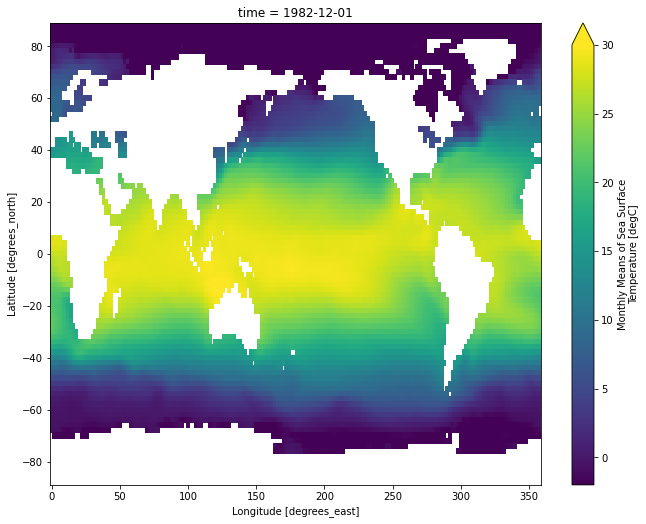

In [15]:
nino = sst.sel(time='12-01-1982')
nino.plot(vmin=-2, vmax=30,figsize=(11,8.5));

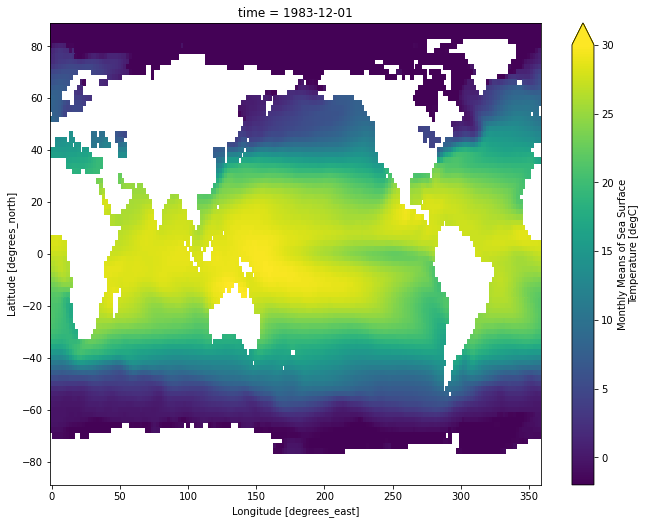

In [16]:
nina = sst.sel(time='12-01-1983')
nina.plot(vmin=-2, vmax=30,figsize=(11,8.5));

## Basic Arithmetic

Xarray dataarrays (and by extension, Dask arrays) and datasets work seamlessly with arithmetic operators and
numpy array functions.

### Exercise: subtract the 1982 data from 1983 and plot the result. You should get a nice sense of the SST variation during an historically large transtion from El Niño to La Niña conditions in the Pacific.

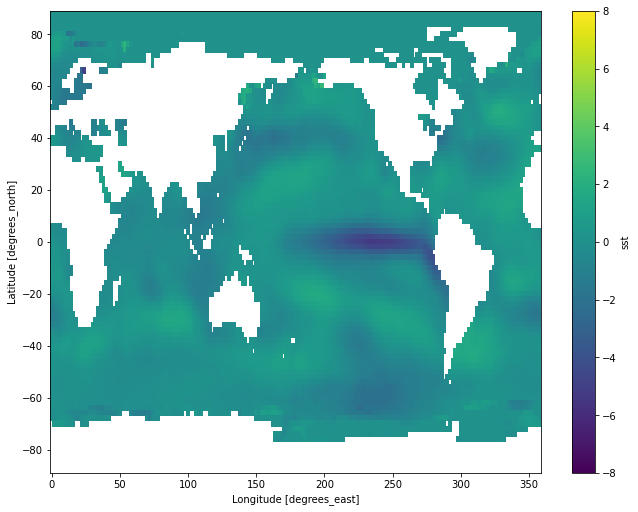

In [17]:
# Write your code here
(nina - nino).plot(vmin=-8,vmax=8,figsize=(11,8.5))

## Reductions

Just as in NumPy and Pandas, we can reduce Xarray DataArrays along any number of axes. In Xarray, we can pass in whatever axis or multiple axes we want, using the `dim` keyword.
1. Calculate the mean over all times. This returns a Dask array for each lat/lon coordinate pair in the Dataset (note, nothing has actually been computed yet!):

In [18]:
sst.mean(dim='time')

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
dask.array<mean_agg-aggregate, shape=(89, 180), dtype=float32, chunksize=(89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

#### Let's do a simple visualization of this 59-year mean. Doing the visualization triggers the computation of the mean from the Dask array!

/knight/anaconda_jan21/envs/pyaos-lesson/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


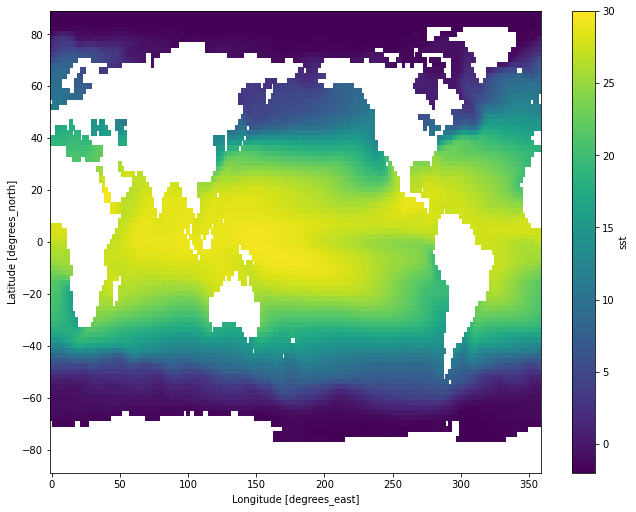

In [19]:
sst.mean(dim='time').plot(figsize=(11,8.5), vmin=-2, vmax=30)

#### Exercise: What would the following cell produce?

In [20]:
sst.mean().compute()

<xarray.DataArray 'sst' ()>
array(13.746263, dtype=float32)

This will produce just a single value (and strictly speaking, a single-valued `DataArray`) ... corresponding to the mean SST over all times and gridpoints.

#### Exercise:
Take the mean of `sst` in both longitude and latitude and make a simple timeseries plot:

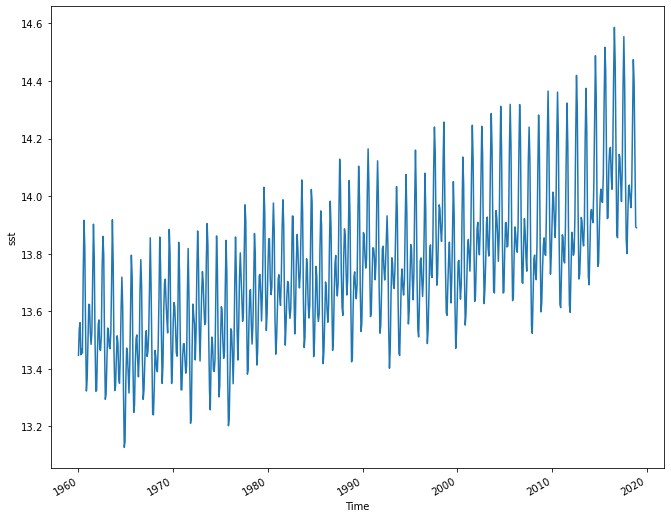

In [21]:
# Write your code here
sst.mean(dim=["lat","lon"]).plot(figsize=(11,8.5))

#### All of the standard Numpy/Pandas reductions (e.g. `min`, `max`, `sum`, `std`, etc.) are available.


### Here we have accessed, analyzed, and visualized data that is housed remotely without having to download a copy of it. While this particular dataset it trivial in terms of size, similar techniques will work effectively on much larger datasets. In the next couple of notebooks, we'll access CMIP6 and HRRR datasets stored in the cloud.

Interested in finding out more, and participating in, the Pangeo community? You are most welcome! Check out https://pangeo.io/about.html#get-involved, as well as the Blog, Forum, and other links on the main Pangeo site!